In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]='TRUE'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pickle
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
import copy
import torch
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
def test_stationarity(timeseries):
    # Dickey-Fuller
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def load_data(data_dir):
    with open(data_dir, 'rb') as f:
        train_data_X, train_data_Y, test_data_X, test_data_Y = pickle.load(f)
    return train_data_X, train_data_Y, test_data_X, test_data_Y

In [5]:
config = {
    "data_dir":'./temp_data/public_data.pt',
}

scaler = torch.load(config['data_dir'])['scaler']
train_data_X, train_data_Y, test_data_X, test_data_Y = torch.load(config['data_dir'])['data']


In [6]:
train_data_X.shape

torch.Size([8012, 24, 11])

In [7]:
test_data_X.shape

torch.Size([2900, 24, 11])

In [8]:
### The last data of train_data_Y point to the end of Jun 30.
train_data = pd.DataFrame(np.array(train_data_Y[:, 0, -1]), columns=['value'])
### The first data of test_data_X is need to connect with train_data_Y
test_data = pd.DataFrame(np.array(test_data_X[:, 0, -1]), columns=['value'])

test_stationarity(train_data['value'])

Results of Dickey-Fuller Test:
Test Statistic                -6.841092e+00
p-value                        1.790470e-09
#Lags Used                     2.700000e+01
Number of Observations Used    7.984000e+03
Critical Value (1%)           -3.431169e+00
Critical Value (5%)           -2.861902e+00
Critical Value (10%)          -2.566963e+00
dtype: float64


In [9]:
train_data

,value
0,0.437966
1,0.387205
2,0.376647
3,0.390251
4,0.395124
...,...
8007,0.287599
8008,0.284124
8009,0.277621
8010,0.273351


In [10]:
test_data

,value
0,0.286469
1,0.281090
2,0.169198
3,0.206083
4,0.183075
...,...
2895,0.013161
2896,0.003515
2897,0.027927
2898,0.036481


<AxesSubplot:>

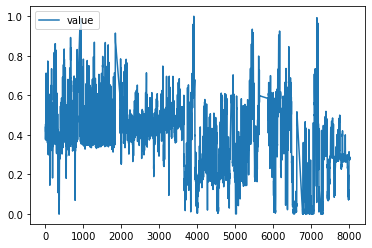

In [11]:
train_data.plot()

In [12]:
#model = ARIMA(train_data['value'], train_exog, order=(6, 0, 6))
model = ARIMA(train_data['value'], order=(6, 1, 6))
res = model.fit()
print(res.summary())

last_index = train_data.index[-1]

C:\Users\HAIZHO\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\HAIZHO\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\HAIZHO\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 8012
Model:                 ARIMA(6, 1, 6)   Log Likelihood               11790.136
Date:                Thu, 21 Dec 2023   AIC                         -23554.271
Time:                        09:58:01   BIC                         -23463.420
Sample:                             0   HQIC                        -23523.176
                               - 8012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1672      1.060     -0.158      0.875      -2.245       1.911
ar.L2          0.0492      0.996      0.049      0.961      -1.904       2.002
ar.L3          0.1880      0.844      0.223      0.8

In [13]:
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)

In [14]:
## make forecast into future 24 samples
all_results = []

for i in range(test_data.shape[0]):
    if i%100 == 0:
        print(i)
    aaa = res.forecast(24)
    #aaa = res.forecast(24)
    all_results.append(aaa)
    
    new_observations = all_data['value'][(last_index+1+i): (last_index+i+2)]
    res = res.extend(new_observations)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800


In [15]:
all_results = np.array(all_results)

In [16]:
## n_baches, n_step
all_results.shape

(2900, 24)

In [17]:
## prepare prediction data for transverse scale
output = copy.deepcopy(test_data_Y)
output[:, :, -1] = torch.from_numpy(all_results)
output.shape

torch.Size([2900, 24, 11])

In [18]:
## transverse scale
all_cooling = []
for i in range(output.shape[1]):
    print('%d th future hour prediction'%(i+1))
    predict_data = scaler.inverse_transform(output[:, i, :])
    actual_data = scaler.inverse_transform(test_data_X[:, i, :])
    
    all_cooling.append([actual_data[:, -1], predict_data[:, -1]])

1 th future hour prediction
2 th future hour prediction
3 th future hour prediction
4 th future hour prediction
5 th future hour prediction
6 th future hour prediction
7 th future hour prediction
8 th future hour prediction
9 th future hour prediction
10 th future hour prediction
11 th future hour prediction
12 th future hour prediction
13 th future hour prediction
14 th future hour prediction
15 th future hour prediction
16 th future hour prediction
17 th future hour prediction
18 th future hour prediction
19 th future hour prediction
20 th future hour prediction
21 th future hour prediction
22 th future hour prediction
23 th future hour prediction
24 th future hour prediction


In [19]:
all_cooling = np.array(all_cooling)

In [20]:
## n_step, (true, actual), n_batches
all_cooling.shape

(24, 2, 2900)

In [21]:
all_cooling_1 = all_cooling[0, :, :]
all_cooling_1 = pd.DataFrame(all_cooling_1.T, columns=['Actual', 'predict'])

In [22]:
all_cooling_1

,Actual,predict
0,35.271825,34.429843
1,34.609477,34.848871
2,20.832663,34.325055
3,25.374125,21.914373
4,22.541295,24.704931
...,...,...
2895,1.620455,1.214823
2896,0.432812,2.111070
2897,3.438550,1.129660
2898,4.491748,3.669045


Text(0.5, 1.0, 'The prediction in the first 28 days')

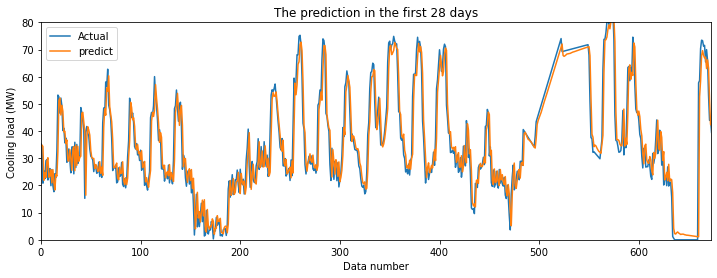

In [23]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)
all_cooling_1.plot(ax=ax)
ax.set(xlim=[0, 24*28], ylim=[0, 80], xlabel='Data number', ylabel='Cooling load (MW)')
ax.set_title('The prediction in the first 28 days')

In [24]:
print('%d-hour-ahead prediction - RMSE = %f'%(1, np.sqrt(mean_squared_error(all_cooling_1['Actual'], all_cooling_1['predict']))))
print('%d-hour-ahead prediction - MAE = %f'%(1, mean_absolute_error(all_cooling_1['Actual'], all_cooling_1['predict'])))

1-hour-ahead prediction - RMSE = 6.750689
1-hour-ahead prediction - MAE = 4.165590


In [25]:
mean_rmse = []
mean_mae = []
mean_mape = []
for i in range(all_cooling.shape[2]):
    mean_rmse.append(np.sqrt(mean_squared_error(all_cooling[:, 0, i], all_cooling[:, 1, i])))
    mean_mae.append(mean_absolute_error(all_cooling[:, 0, i], all_cooling[:, 1, i]))

In [26]:
print('%d-hour-ahead prediction - RMSE = %f'%(24, np.mean(mean_rmse)))
print('%d-hour-ahead prediction - MAE = %f'%(24, np.mean(mean_mae)))

24-hour-ahead prediction - RMSE = 15.927132
24-hour-ahead prediction - MAE = 13.331157
